In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
# Load the dataset
df = pd.read_csv('/home/bibin/MAI/4th sem/Semantic/movies.csv')

# Sample the dataset to df_sampled
df_sampled = df.sample(frac=0.25, replace=False, random_state=1)

In [3]:
df_sampled.head()

Unnamed: 0        genre  \
10689       10689  documentary   
32392       32392        short   
47445       47445        short   
11729       11729    adventure   
1298         1298  documentary   

                                             description  
10689  This documentary film is a heartfelt glimpse a...  
32392  According to an old Chinese fairytale, the god...  
47445  In 1929, in Chicago, 12 year old Larry Adler w...  
11729  England Cricket hero Freddie Flintoff spends e...  
1298   Three gravediggers lovingly maintain the peace...

In [4]:
# Replace low-frequency genres with 'other' in df_sampled
threshold = 390  # Define your threshold
genre_counts = df_sampled['genre'].value_counts()
small_genres = genre_counts[genre_counts < threshold].index
df_sampled['genre'] = df_sampled['genre'].replace(small_genres, 'other')

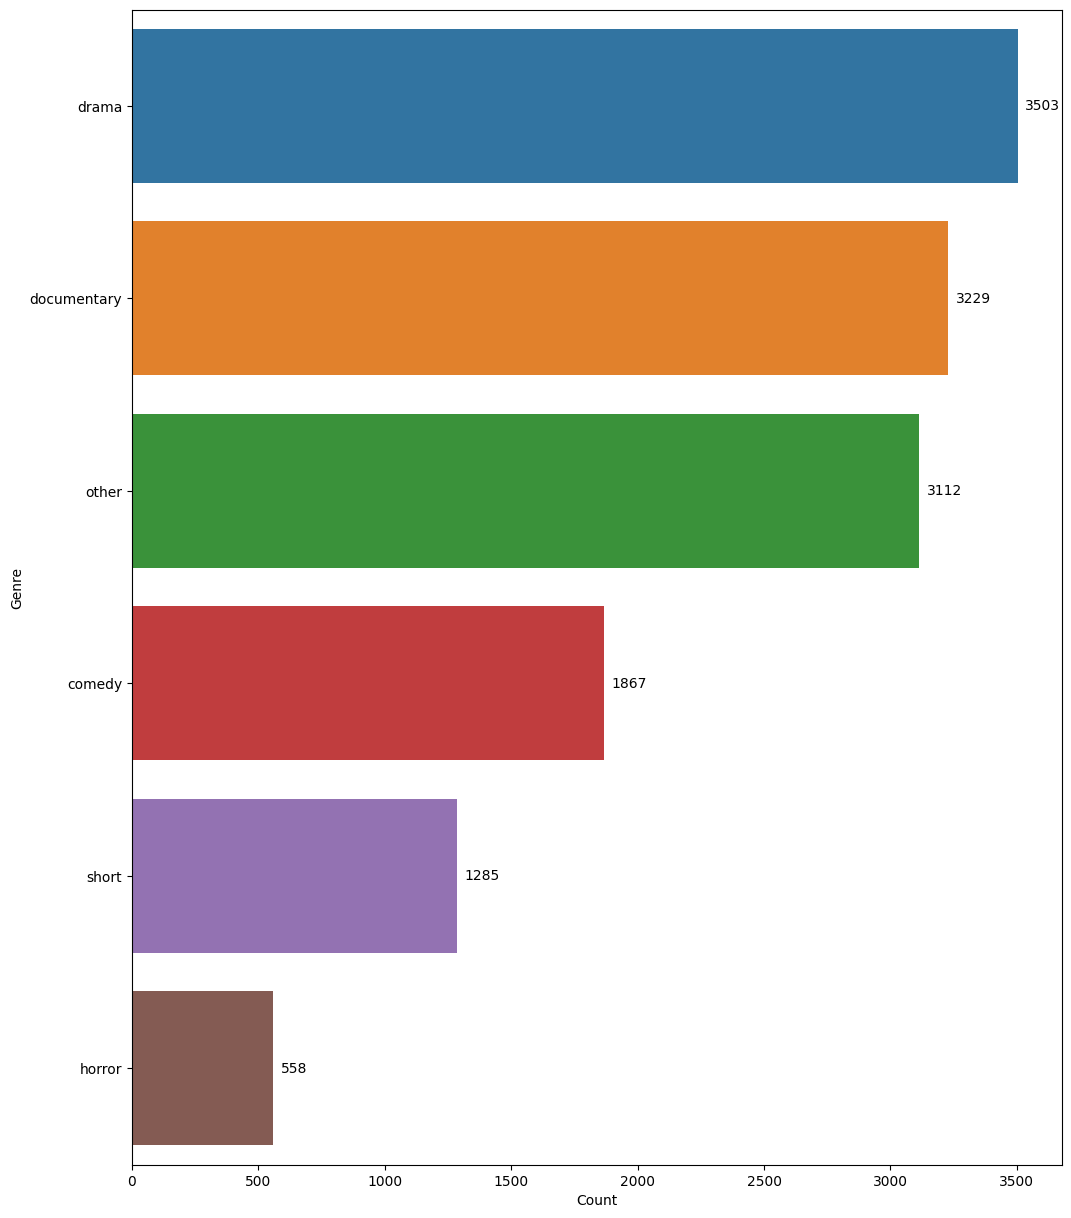

In [5]:
# Count the occurrences of each genre
genre_counts = df_sampled['genre'].value_counts()

# Create a dataframe with this count data
genres_df_sampled = genre_counts.reset_index()
genres_df_sampled.columns = ['Genre', 'Count']

# Sort the dataframe by the 'Count' column in descending order for plotting
genres_df_sampled = genres_df_sampled.sort_values('Count', ascending=False)

# Plotting with the count displayed on each bar
plt.figure(figsize=(12,15))
ax = sns.barplot(data=genres_df_sampled, x='Count', y='Genre')

# Adding the text labels for each bar
for p in ax.patches:
    ax.annotate(f"{int(p.get_width())}", 
                (p.get_width() + 3, p.get_y() + p.get_height() / 2), 
                xytext=(5, 0),  # 5 points horizontal offset
                textcoords='offset points',
                ha='left', 
                va='center')

ax.set(ylabel='Genre', xlabel='Count')
plt.show()

In [6]:
# Encode the 'genre' labels from df_sampled
label_encoder = LabelEncoder()
df_sampled['genre_labels'] = label_encoder.fit_transform(df_sampled['genre'])

In [7]:
from sklearn.model_selection import train_test_split

# First, determine the size of 1% of the entire dataset
test_size = int(len(df_sampled) * 0.01)

# Determine the size of the training set (4% of the entire dataset)
train_size = int(len(df_sampled) * 0.04)

# If the sum of train_size and test_size is greater than the total, adjust them
total_samples = len(df_sampled)
if train_size + test_size > total_samples:
    test_size = total_samples - train_size

# Split the data into train and test sets
train_df, test_df = train_test_split(df_sampled, train_size=train_size, test_size=test_size, random_state=1)

In [8]:
# Tokenize the descriptions from df_sampled
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_tokenized_descriptions = [tokenizer(description, padding='max_length', truncation=True, max_length=256, return_tensors="pt") for description in train_df['description']]

In [9]:
# Tokenize test descriptions
test_tokenized_descriptions = [tokenizer(description, padding='max_length', truncation=True, max_length=256, return_tensors="pt") for description in test_df['description']]
test_labels = test_df['genre_labels'].tolist()

In [10]:
# Adjust the BertForSequenceClassification num_labels parameter if needed
unique_genre_count = df_sampled['genre'].nunique()
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=unique_genre_count)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# Create a dataset and dataloader from the sampled and processed data
train_labels = train_df['genre_labels'].tolist()

class MovieDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # Retrieve the encoding for the specific index
        encoding = self.encodings[idx]

        # Extract input_ids, attention_mask, and create label tensor
        item = {
            'input_ids': encoding['input_ids'].squeeze(0),  # Remove batch dimension
            'attention_mask': encoding['attention_mask'].squeeze(0)  # Remove batch dimension
        }
        item['labels'] = torch.tensor(self.labels[idx])

        return item

    def __len__(self):
        return len(self.labels)
    
# Create the train and test datasets
train_dataset = MovieDataset(train_tokenized_descriptions, train_labels)
test_dataset = MovieDataset(test_tokenized_descriptions, test_labels)

# Create the DataLoaders for train and test datasets
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [12]:
# Training loop
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=1e-1)
num_epochs = 1

In [ ]:
import matplotlib.pyplot as plt

# Assuming other necessary imports and initializations are done above this point

num_epochs = 1
optimizer = AdamW(model.parameters(), lr=1e-1)

# Lists to store loss values
iteration_losses = []
epoch_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    epoch_start_time = time.time()
    
    for batch_idx, batch in enumerate(train_dataloader):
        iteration_start_time = time.time()
        
        optimizer.zero_grad()
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        
        loss = outputs.loss
        iteration_losses.append(loss.item())  # Collect loss for plotting
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

        iteration_end_time = time.time()
        iteration_duration = iteration_end_time - iteration_start_time
        
        print(f"Iteration {batch_idx+1}/{len(train_dataloader)}: Loss = {loss.item():.4f}, Time = {iteration_duration:.2f}s")

    epoch_losses.append(epoch_loss / len(train_dataloader))  # Collect average loss for epoch
    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time
    
    print(f"Epoch {epoch+1}/{num_epochs}: Average Loss = {epoch_loss / len(train_dataloader):.4f}, Duration = {epoch_duration:.2f}s")

In [ ]:
# Plotting the training curve
plt.figure(figsize=(12, 8))
plt.plot(iteration_losses, label='Iteration loss')
plt.plot(np.arange(len(epoch_losses)) * len(train_dataloader), epoch_losses, label='Epoch loss', marker='o')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Curve')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

# Put the model in evaluation mode
model.eval()

# Initialize lists to store true labels and model predictions
true_labels = []
model_predictions = []

# No gradient needed for evaluation
with torch.no_grad():
    for batch in test_dataloader:
        # Get input data and labels from the batch
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        # Forward pass, get model predictions
        outputs = model(input_ids, attention_mask=attention_mask)

        # Move logits and labels to CPU
        logits = outputs.logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        # Convert logits to predicted class indices
        batch_predictions = np.argmax(logits, axis=1)

        # Store predictions and true labels
        model_predictions.extend(batch_predictions)
        true_labels.extend(label_ids)

# Calculate accuracy
accuracy = accuracy_score(true_labels, model_predictions)
print(f"Accuracy on Test Set: {accuracy:.4f}")
